In [2]:
%matplotlib inline
from fredapi import Fred
fred = Fred(api_key='48602a9ca88b2b0eefabd0904eaeb6be')
#data = fred.get_series('SP500')
import pandas as pd
pd.options.display.max_colwidth = 60
import numpy as np
import matplotlib.pyplot as plt
import urllib3
import urllib
from IPython.core.pylabtools import figsize
figsize(20, 5)
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import exp, expm1
import statsmodels.api as sm


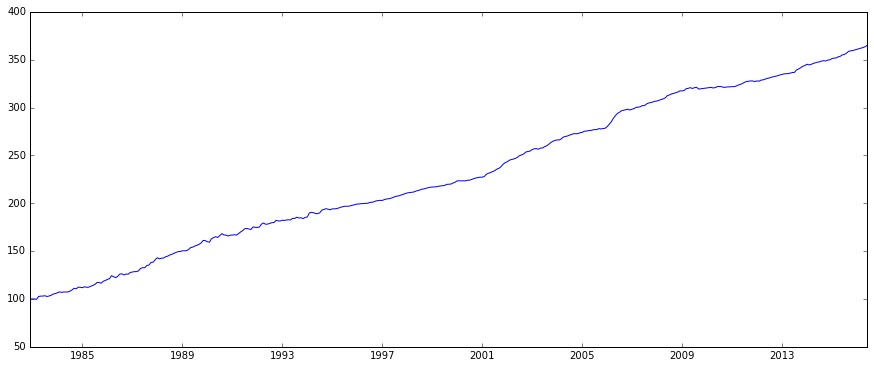

In [6]:
#y = fred.get_series('DEUCPIALLMINMEI')

y = fred.get_series('CUURA101SEHC01')
plt.plot(y)

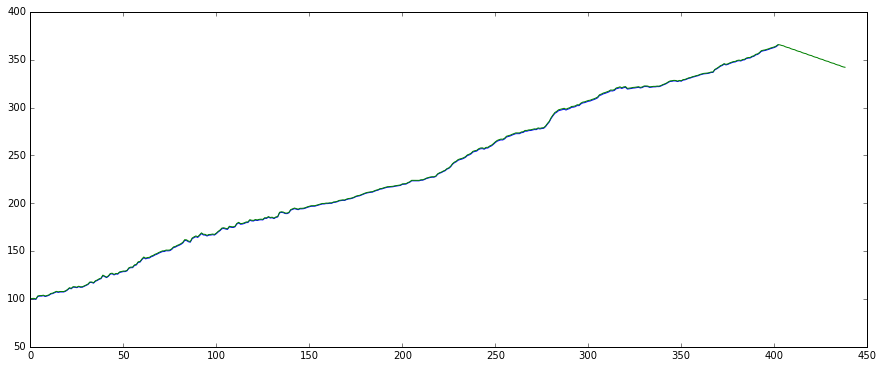

In [7]:
### Implementing Exponential Smoothing###

### Test series

series = y.values

plt.plot(series)

def ini_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def ini_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = len(series)//slen
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def Exponential_Smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = ini_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = ini_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = len(series) - i + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            # Additive ES            
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result



#print(initial_trend(y, 12))
#print(initial_trend(series, 12))
#print(initial_seasonal_components(series, 12))
#print(initial_seasonal_components(series, 12))
# slen may change with sample rate, annual, quarter, monthly
series_pred = Exponential_Smoothing(series, 3, 0.716, 0.029, 0.993, 36)
plt.plot(series_pred)

In [8]:
### Optimizing Exponential Smoothing Parameters ###
'''
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

series_pred = [31,20,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]
'''
series = y.values
#print(mean_squared_error(series, series_pred))
# alpha, beta, gamma

resolution = 20
alpha = np.linspace(0.0, 1.0, resolution)
beta = np.linspace(0.0, 1.0, resolution)
gamma = np.linspace(0.0, 1.0, resolution)

def opt_paras(series, slen):
    Min_MSE = mean_squared_error(series, Exponential_Smoothing(series, slen, 0.001, 0.001, 0.001, 0))
    opt_alpha = 0.001
    opt_beta = 0.001
    opt_gamma = 0.001
    for i in range(0, resolution):
        for j in range(0, resolution):
            for k in range(0, resolution):
                new_MSE = mean_squared_error(series, Exponential_Smoothing(series, slen, alpha[i], beta[j], gamma[k], 0))
                if (new_MSE < Min_MSE):
                    Min_MSE = new_MSE
                    opt_alpha = alpha[i]
                    opt_beta = beta[j]
                    opt_gamma = gamma[k]
    series_pred = Exponential_Smoothing(series, slen, opt_alpha, opt_beta, opt_gamma, 0)
    return opt_alpha, opt_beta, opt_gamma, mean_squared_error(series, series_pred)               
                    
print(opt_paras(series, 12))                    
                
                


(0.0, 0.36842105263157893, 0.94736842105263153, 0.2068211696402617)


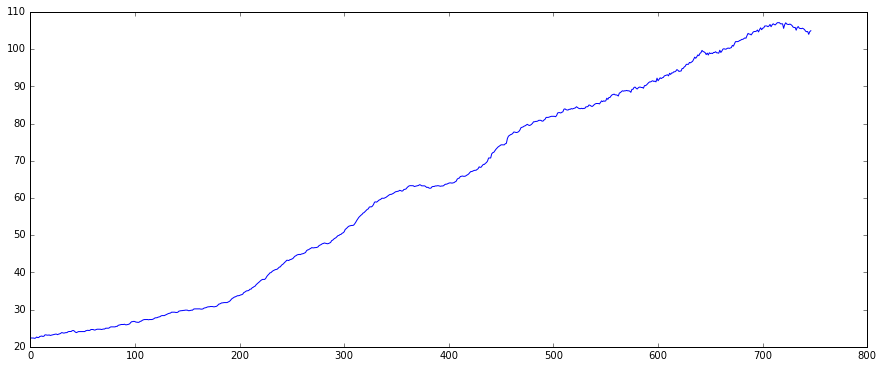

In [83]:
plt.plot(series_pred)

In [102]:
series = y.values
future_windows = 36
series_pred = Exponential_Smoothing(series, 12, 0.716, 0.029, 0.993, future_windows)
#plt.plot(series_pred)
#print(mean_squared_error(series, series_pred))
print(series_pred[len(series) + 1])
print(series_pred[len(series) + future_windows - 1])

106.679459321
103.843483037


C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


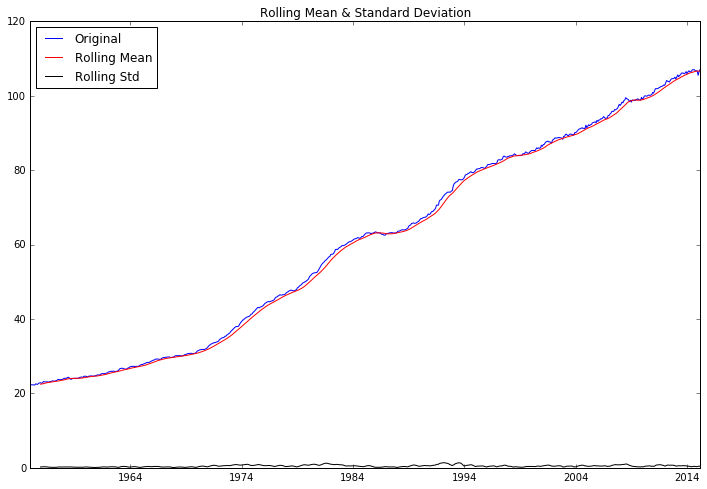

Results of Dickey-Fuller Test:
Test Statistic                  -0.052198
p-value                          0.953996
#Lags Used                      12.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (10%)            -2.568942
Critical Value (5%)             -2.865619
dtype: float64


In [4]:
### test stationary ###
y = fred.get_series('DEUCPIALLMINMEI')
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 
    
test_stationarity(y)    

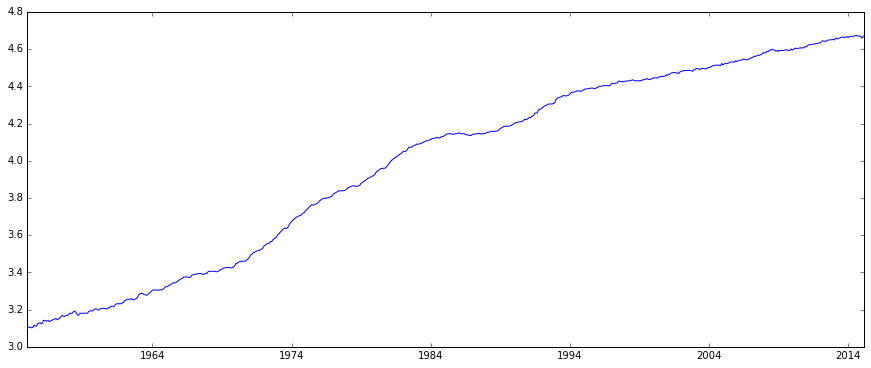

In [5]:
ts = y
ts_log = np.log(ts)
plt.plot(ts_log)

C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
  from ipykernel import kernelapp as app
C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


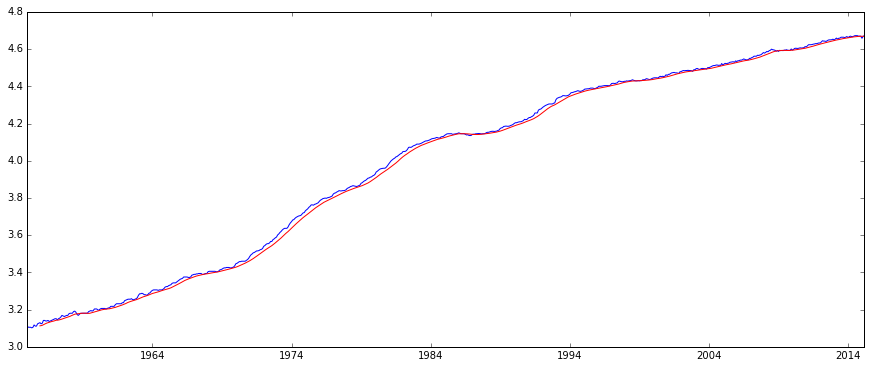

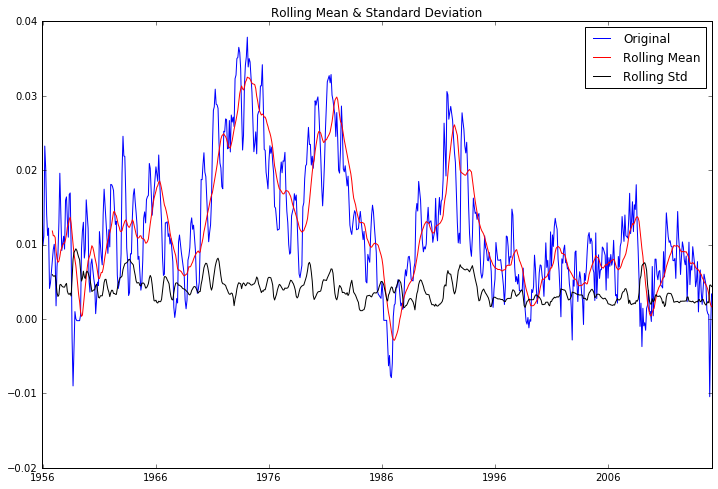

Results of Dickey-Fuller Test:
Test Statistic                  -3.096768
p-value                          0.026793
#Lags Used                      12.000000
Number of Observations Used    699.000000
Critical Value (1%)             -3.439740
Critical Value (10%)            -2.568977
Critical Value (5%)             -2.865684
dtype: float64


In [6]:
### How to make stationary (Trend): Moving average###
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,adjust=True,halflife=12,min_periods=0).mean()
  from ipykernel import kernelapp as app
C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


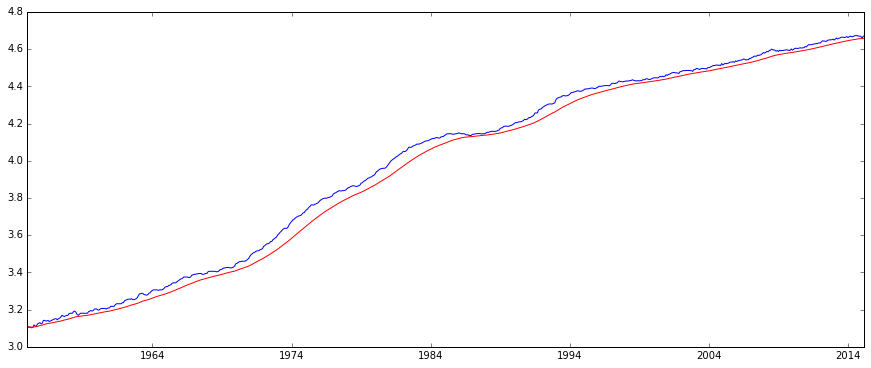

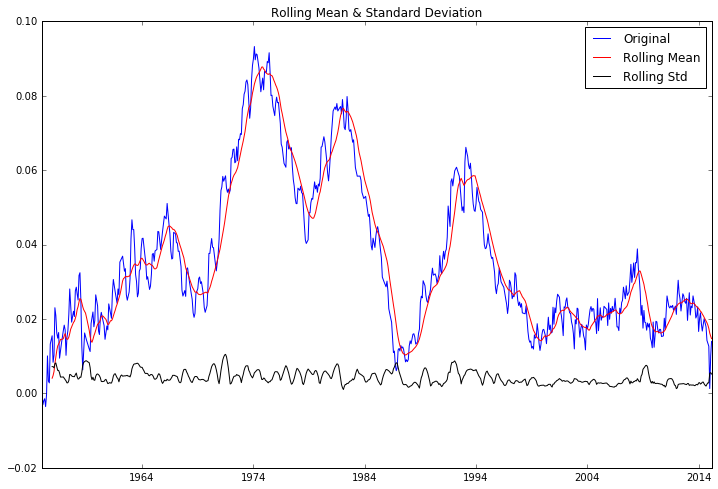

Results of Dickey-Fuller Test:
Test Statistic                  -2.570648
p-value                          0.099217
#Lags Used                      12.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (10%)            -2.568942
Critical Value (5%)             -2.865619
dtype: float64


In [7]:
### How to make stationary (Trend): Exponentially Weighted Moving average###
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


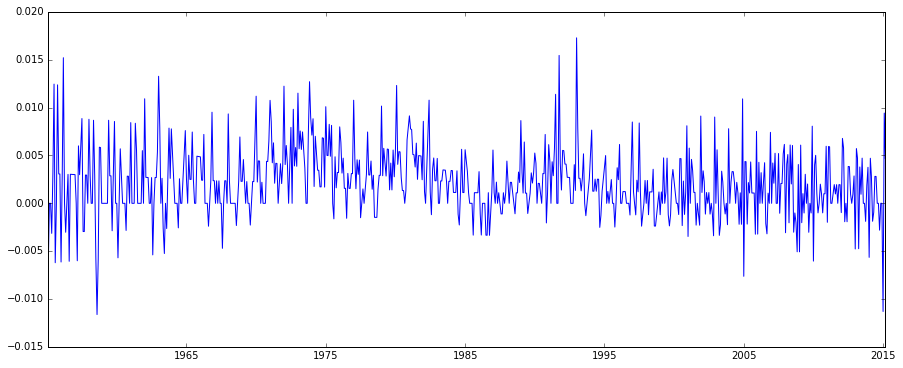

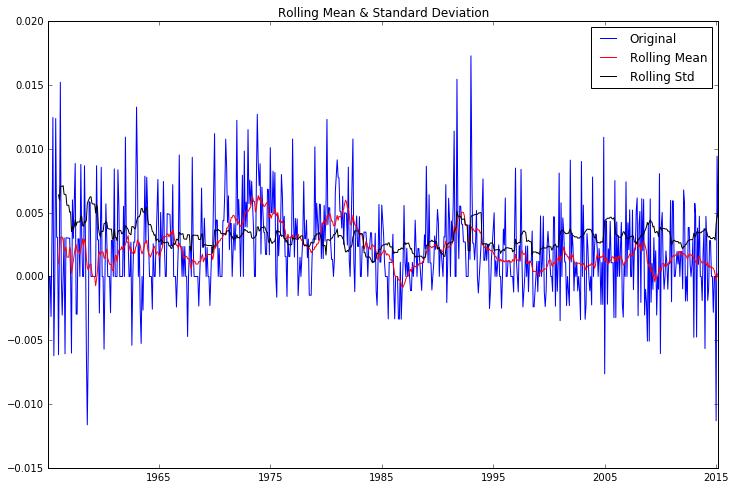

Results of Dickey-Fuller Test:
Test Statistic                  -3.129111
p-value                          0.024473
#Lags Used                      11.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (10%)            -2.568942
Critical Value (5%)             -2.865619
dtype: float64


In [8]:
### Eliminating Trend and Seasonality: Differencing ###
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
C:\Users\syc\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


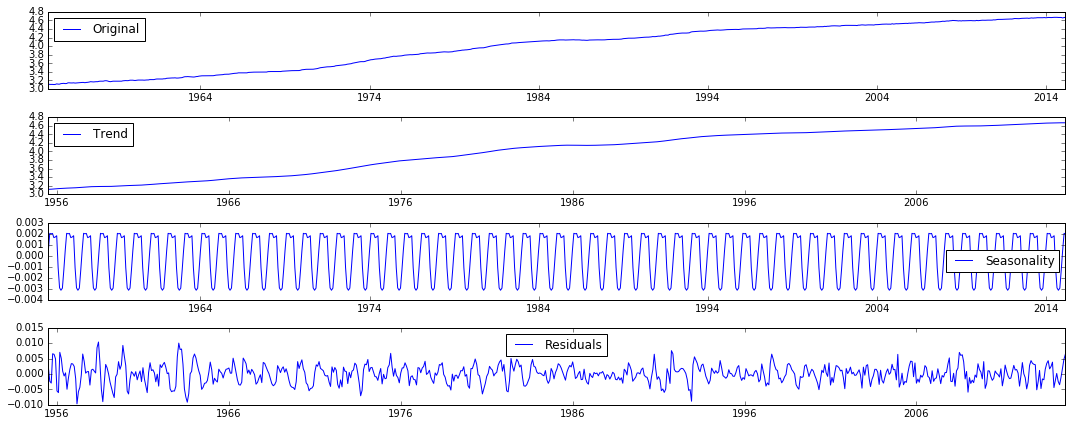

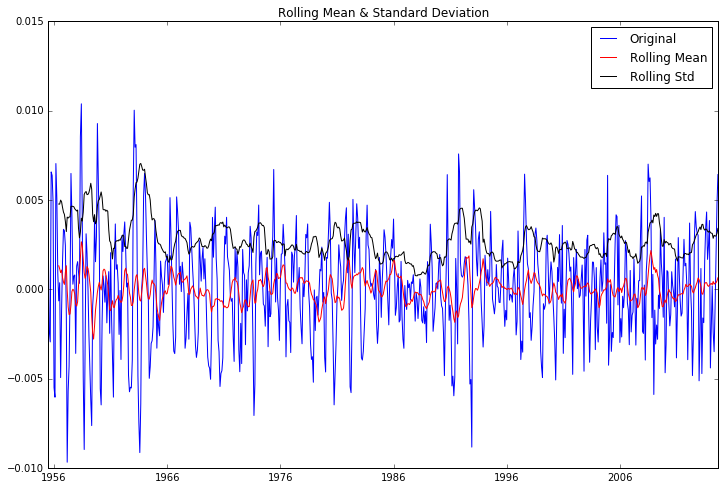

Results of Dickey-Fuller Test:
Test Statistic                -1.007676e+01
p-value                        1.218050e-17
#Lags Used                     1.200000e+01
Number of Observations Used    6.980000e+02
Critical Value (1%)           -3.439753e+00
Critical Value (10%)          -2.568980e+00
Critical Value (5%)           -2.865690e+00
dtype: float64


In [9]:
### Eliminating Trend and Seasonality: Decomposition###
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

'\np – The lag value where the PACF chart crosses the upper confidence interval for the first time. \nIf you notice closely, in this case p=2.\nq – The lag value where the ACF chart crosses the upper confidence interval for the first time. \nIf you notice closely, in this case q=3.\n'

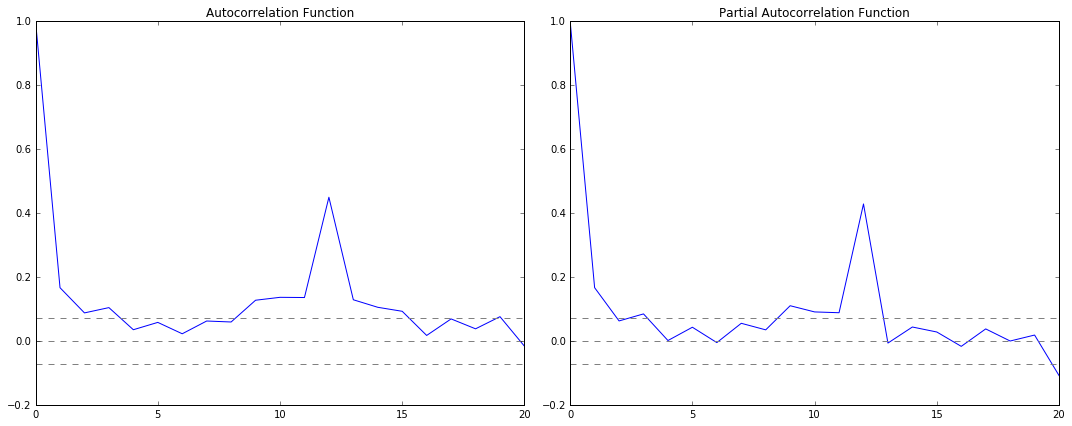

In [10]:
### Forecasting a Time Series, parameters determination ###
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

'''
p – The lag value where the PACF chart crosses the upper confidence interval for the first time. 
If you notice closely, in this case p=2.
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. 
If you notice closely, in this case q=3.
'''

C:\Users\syc\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


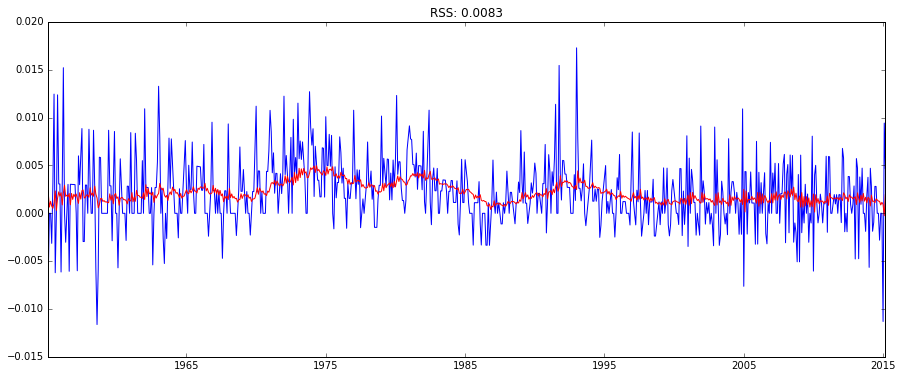

In [238]:
### Forecasting a Time Series, ARIMA prediction ###
from statsmodels.tsa.arima_model import ARIMA
p = 3
q = 2
model = ARIMA(ts_log, order=(p, 1, q))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

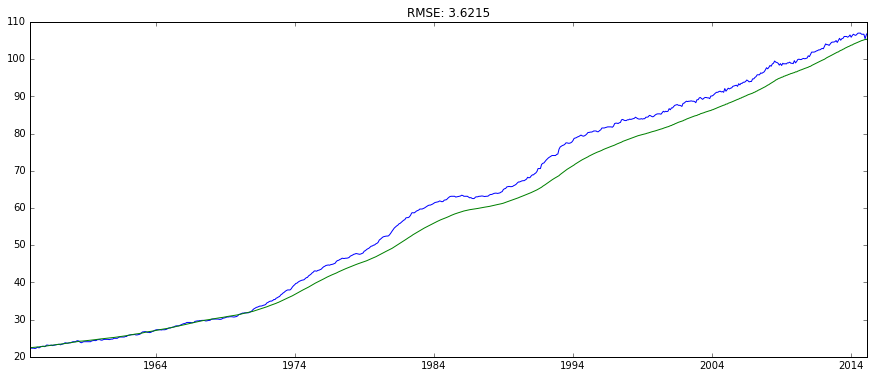

In [239]:
### Taking it back to original scale ###
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#print(predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
# mean_squared_error
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
#plt.title('MSE: %.4f'% mean_squared_error(ts.values, predictions_ARIMA.values))
#print(predictions_ARIMA_diff)

In [14]:
 print(fred.get_series('DEUCPIALLMINMEI'))

1955-01-01     22.448966
1955-02-01     22.309097
1955-03-01     22.309097
1955-04-01     22.309097
1955-05-01     22.239162
1955-06-01     22.309097
1955-07-01     22.588834
1955-08-01     22.448966
1955-09-01     22.448966
1955-10-01     22.728703
1955-11-01     22.798638
1955-12-01     22.868572
1956-01-01     22.728703
1956-02-01     22.798638
1956-03-01     23.148310
1956-04-01     23.148310
1956-05-01     23.078376
1956-06-01     23.078376
1956-07-01     23.148310
1956-08-01     23.008441
1956-09-01     23.078376
1956-10-01     23.148310
1956-11-01     23.218245
1956-12-01     23.288179
1957-01-01     23.358114
1957-02-01     23.358114
1957-03-01     23.218245
1957-04-01     23.358114
1957-05-01     23.428048
1957-06-01     23.567917
                 ...    
2012-10-01    104.608717
2012-11-01    104.708726
2012-12-01    105.008751
2013-01-01    104.508709
2013-02-01    105.108759
2013-03-01    105.608801
2013-04-01    105.108759
2013-05-01    105.508792
2013-06-01    105.608801


In [16]:
y = fred.get_series('DEUCPIALLMINMEI')
dta = y 
dta.index = pd.DatetimeIndex(start='1955-01', end='2015-04', freq='M')
#print(dta.index)
res = sm.tsa.ARMA(dta, (2, 3)).fit()
fig, ax = plt.subplots()
ax = dta.ix['1955-01-31':].plot(ax=ax)
fig = res.plot_predict('2014-01-31', '2018-12-31', dynamic=True, ax=ax, plot_insample=False)
plt.show()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

C:\Users\syc\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


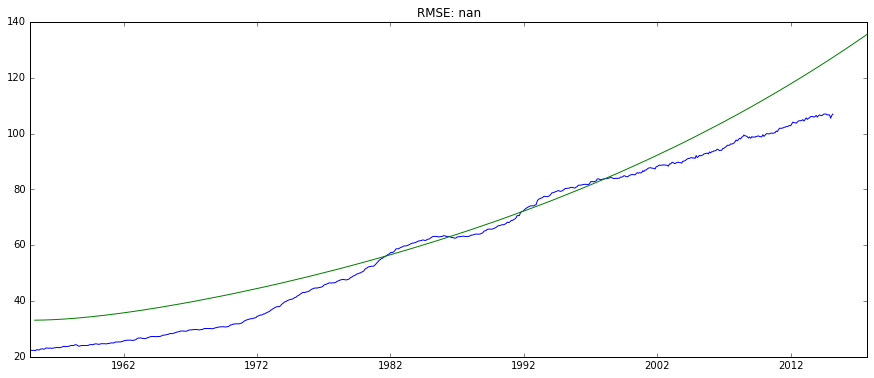

In [246]:
#print(y) p + q - 1
# predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff = results_ARIMA.predict(start = p + q - 1, end= 753, dynamic= True) 
#print(predictions_ARIMA_diff)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#print(len(predictions_ARIMA_diff_cumsum))
#print(ts_log.ix[0])
#print(predictions_ARIMA_diff.index)
predictions_ARIMA_log = pd.Series(predictions_ARIMA_diff.ix[0], index=predictions_ARIMA_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 227)
#print(len(predictions_ARIMA_log))
predictions_ARIMA = np.exp(predictions_ARIMA_log + p + q - 1.5)
plt.plot(ts)
plt.plot(predictions_ARIMA)
# mean_squared_error
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA[:len(ts)]-ts)**2)/len(ts)))
#plt.title('MSE: %.4f'% mean_squared_error(ts.values, predictions_ARIMA.values))

C:\Users\syc\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


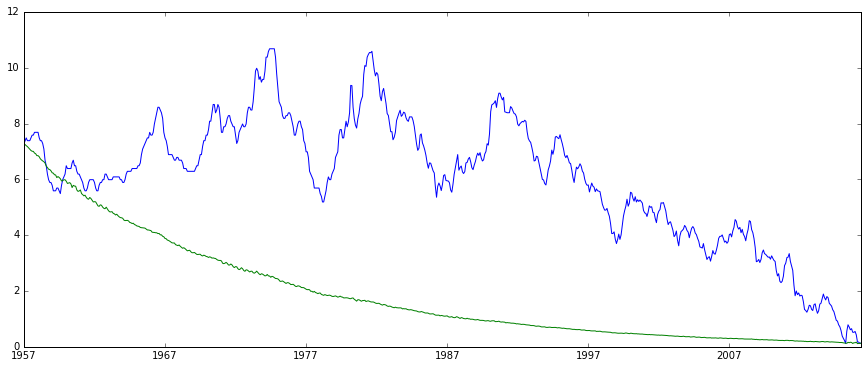

In [250]:
y = fred.get_series('INTGSBDEM193N')
ts = y
ts_log = np.log(ts)
p = 3
q = 6
model = ARIMA(ts_log, order=(p, 1, q))  
results_ARIMA = model.fit(disp=-1) 
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#print(predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)



C:\Users\syc\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


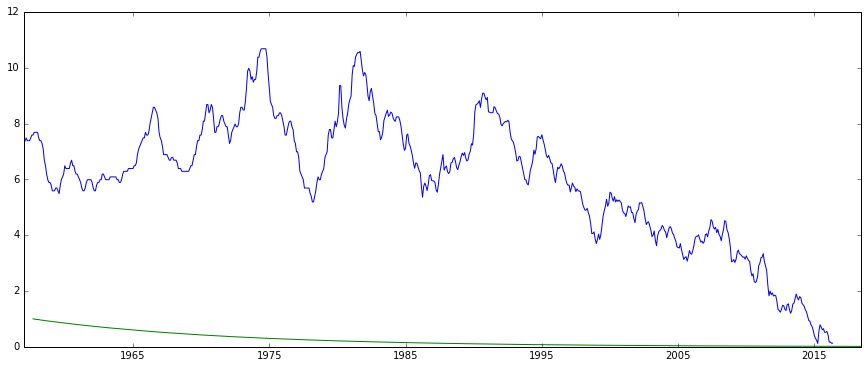

In [252]:
### Exension

#print(y) p + q - 1
# predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff = results_ARIMA.predict(start = p + q - 1, end= len(y) + 24, dynamic= True) 
#print(predictions_ARIMA_diff)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#print(len(predictions_ARIMA_diff_cumsum))
#print(ts_log.ix[0])
#print(predictions_ARIMA_diff.index)
predictions_ARIMA_log = pd.Series(predictions_ARIMA_diff.ix[0], index=predictions_ARIMA_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 227)
#print(len(predictions_ARIMA_log))
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)

In [ ]:
y = fred.get_series('INTGSBDEM193N')
print(y)

   SUNACTIVITY
0          5.0
1         11.0
2         16.0
3         23.0
4         36.0


C:\Users\syc\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1724: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


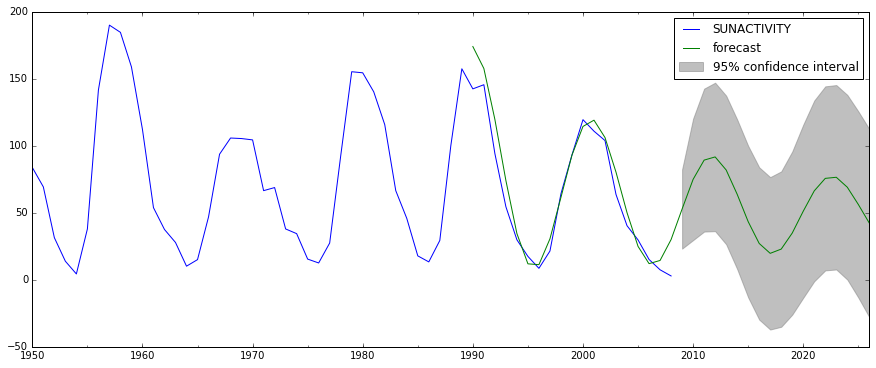

In [293]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
print(dta.head())
dta.index = pd.DatetimeIndex(start='1700', end='2009', freq='A')
res = sm.tsa.ARMA(dta, (3, 4)).fit()
fig, ax = plt.subplots()
ax = dta.ix['1950':].plot(ax=ax)
fig = res.plot_predict('1990', '2026', dynamic=True, ax=ax, plot_insample=False)
plt.show()

C:\Users\syc\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


456.132083029


C:\Users\syc\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1724: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


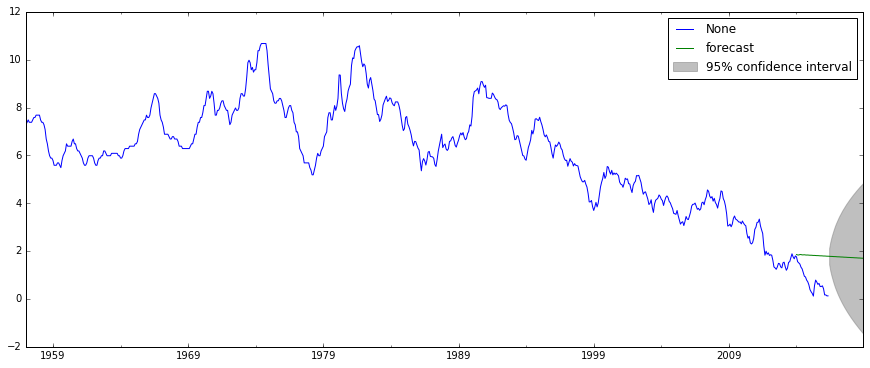

In [19]:
y = fred.get_series('INTGSBDEM193N')
dta = y 
dta.index = pd.DatetimeIndex(start='1957-01', end='2016-06', freq='M')
#print(dta.index)
res = sm.tsa.ARMA(dta, (6, 4)).fit()
print(sum(res.resid.values**2))
fig, ax = plt.subplots()
ax = dta.ix['1957-01-31':].plot(ax=ax)
fig = res.plot_predict('2014-01-31', '2018-12-31', dynamic=True, ax=ax, plot_insample=False)
plt.show()

3 2


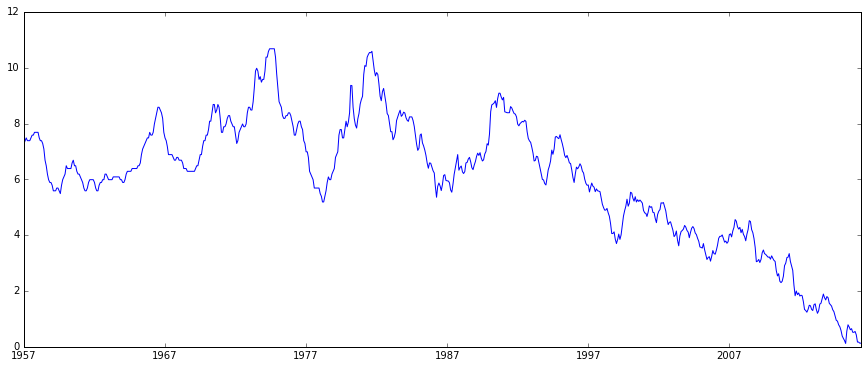

In [300]:
# this is the nsteps ahead predictor function

from statsmodels.tsa.arima_model import _arma_predict_out_of_sample
y = fred.get_series('INTGSBDEM193N')
res = sm.tsa.ARMA(y, (3, 2)).fit(trend="nc")

# get what you need for predicting one-step ahead
params = res.params
residuals = res.resid
p = res.k_ar
q = res.k_ma
k_exog = res.k_exog
k_trend = res.k_trend
steps = 5
print(p, q)
_arma_predict_out_of_sample(params, steps, residuals, p, q, k_trend, k_exog, endog=y, exog=None, start=len(y))
plt.plot(y)